In [1]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

filepath = os.path.abspath('')
utilpath = f'{filepath}/../util/'
sys.path.append(utilpath)
data_dir = f'{filepath}/../data/'

# melb_data = pd.read_hdf(f'{data_dir}/melb_data_outliers_removed.h5')
melb_data = pd.read_hdf(f'{data_dir}/melb_data.h5')
melb_data['Car'] = melb_data['Car'].astype(pd.Int64Dtype())
melb_data['YearBuilt'] = melb_data['YearBuilt'].astype(pd.Int64Dtype())

melb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13580 entries, 0 to 13579
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         13580 non-null  object        
 1   Address        13580 non-null  object        
 2   Rooms          13580 non-null  int64         
 3   Type           13580 non-null  object        
 4   Price          13580 non-null  float64       
 5   Method         13580 non-null  object        
 6   SellerG        13580 non-null  object        
 7   Date           13580 non-null  datetime64[ns]
 8   Distance       13580 non-null  float64       
 9   Postcode       13580 non-null  float64       
 10  Bedroom2       13580 non-null  int64         
 11  Bathroom       13580 non-null  int64         
 12  Car            13518 non-null  Int64         
 13  Landsize       13580 non-null  float64       
 14  BuildingArea   7130 non-null   float64       
 15  YearBuilt      8205

In [2]:
melb_data.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Latitude,Longitude,Propertycount,Month
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13518.0,13580.000000,7130.000000,8205.0,13580.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216,7454.417378,7.052283
std,0.955748,6.393107e+05,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916,4378.581772,2.536034
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.0,0.000000,0.000000,1196.0,-38.182550,144.431810,249.000000,1.000000
25%,2.000000,6.500000e+05,6.100000,3044.000000,2.000000,1.000000,1.0,177.000000,93.000000,1940.0,-37.856822,144.929600,4380.000000,5.000000
50%,3.000000,9.030000e+05,9.200000,3084.000000,3.000000,1.000000,2.0,440.000000,126.000000,1970.0,-37.802355,145.000100,6555.000000,7.000000
75%,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.0,651.000000,174.000000,1999.0,-37.756400,145.058305,10331.000000,9.000000
max,10.000000,9.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.0,433014.000000,44515.000000,2018.0,-37.408530,145.526350,21650.000000,12.000000


In [3]:
pd.concat([
    melb_data.isnull().sum(), 
    melb_data.isna().sum()
], axis=1).rename(columns={0: 'null', 1: 'na'})

,null,na
Suburb,0,0
Address,0,0
Rooms,0,0
Type,0,0
Price,0,0
Method,0,0
SellerG,0,0
Date,0,0
Distance,0,0
Postcode,0,0


In [4]:
missing_features = ['Car', 'BuildingArea', 'YearBuilt', 'CouncilArea']
melb_misses = melb_data[missing_features].loc[melb_data.loc[:, missing_features].isnull().any(axis=1)]
melb_misses

,Car,BuildingArea,YearBuilt,CouncilArea
0,1,NaN,<NA>,Yarra
3,1,NaN,<NA>,Yarra
5,0,NaN,<NA>,Yarra
8,1,NaN,<NA>,Yarra
10,1,NaN,<NA>,Yarra
...,...,...,...,...
13575,2,NaN,1981,NaN
13576,2,133.0,1995,NaN
13577,4,NaN,1997,NaN
13578,5,157.0,1920,NaN


In [5]:
na_counts = melb_misses.isna().sum(axis=1)
na_counts, na_counts.max()

(0        2
 3        2
 5        2
 8        2
 10       2
         ..
 13575    2
 13576    1
 13577    2
 13578    1
 13579    1
 Length: 7384, dtype: int64,
 4)

In [6]:
# Find out what combinations of na appear often

mis = pd.MultiIndex.from_product([[0, 1] for _ in range(4)], names=missing_features)

def to_01(na_features):
    mi = [0,0,0,0]
    for i, missing_feature in enumerate(missing_features):
        if missing_feature in na_features:
            mi[i] = 1
    return tuple(mi)

na_feature_counts = pd.DataFrame(0, index=mis, columns=['count'])

# The following is slow (~ 4 sec) ...
# for idx, row in melb_misses.iterrows():
#     na_features = row[ row.isna() ].index
#     na_feature_counts.loc[to_01(na_features)] += 1

# ... therefore, use a dictionary as a proxy
dct = { mi: 0 for mi in mis }

for _, row in melb_misses.iterrows():
    na_features = row[ row.isna() ].index

    dct[to_01(na_features)] += 1

for mi, count in dct.items():
    na_feature_counts.loc[mi] = count 

na_feature_counts.sort_values(by='count')

count
Car BuildingArea YearBuilt CouncilArea       
0   0            0         0                0
1   0            0         0                0
                 1         0                0
    1            0         0                0
                 1         0                0
    0            1         1                1
    1            0         1                3
0   0            1         1               21
1   0            0         1               28
    1            1         1               30
0   1            0         1               92
    0            1         0              250
    1            1         1              560
    0            0         1              634
    1            0         0             1252
                 1         0             4513

Most common NA combinations:
* `(BuildingArea, YearBuilt)` 4513
* `(BuildingArea)` 1252
* `(Car)` 634
* `(BuildingArea, YearBuilt, CouncilArea)` 560

<Axes: xlabel='YearBuilt', ylabel='BuildingArea'>

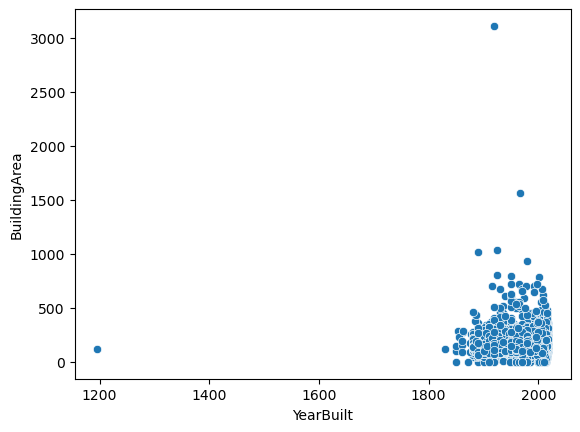

In [7]:
sns.scatterplot(data=melb_data, x='YearBuilt', y='BuildingArea')